In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import unidecode
from tqdm import tqdm

In [2]:
data = pd.read_csv('drom.csv',index_col=[0])

In [3]:
data.head()

,Цена,Город,Модель,Год,Коробка передач,Привод,Тип кузова,Цвет,"Пробег, км",Руль,Особые отметки,Поколение,Комплектация,Пробег
0,915000,Якутск,Toyota Allion,2011,вариатор,4WD,NaN,серый,130 000,правый,NaN,"2 поколение, рестайлинг",1.8 A18 G package luxury edition 4WD,NaN
1,599000,Владивосток,Toyota Allion,2007,вариатор,передний,NaN,голубой,150 000,правый,NaN,2 поколение,1.8 A18 S package,NaN
2,680000,Находка,Toyota Allion,2007,вариатор,передний,NaN,зеленый,235 000,правый,NaN,2 поколение,NaN,NaN
3,777777,Большой Камень,Toyota Allion,2008,вариатор,передний,NaN,черный,156 270,правый,NaN,2 поколение,1.8 A18 S package,NaN
4,750000,Иркутск,Toyota Allion,2007,вариатор,передний,NaN,зеленый,199 000,правый,NaN,2 поколение,1.8 A18,NaN


In [4]:
data.dtypes

Цена                int64
Город              object
Модель             object
Год                 int64
Коробка передач    object
Привод             object
Тип кузова         object
Цвет               object
Пробег, км         object
Руль               object
Особые отметки     object
Поколение          object
Комплектация       object
Пробег             object
dtype: object

Цена - 0%
Город - 0%
Модель - 0%
Год - 0%
Коробка передач - 2%
Привод - 1%
Тип кузова - 52%
Цвет - 4%
Пробег, км - 14%
Руль - 6%
Особые отметки - 97%
Поколение - 4%
Комплектация - 42%
Пробег - 87%


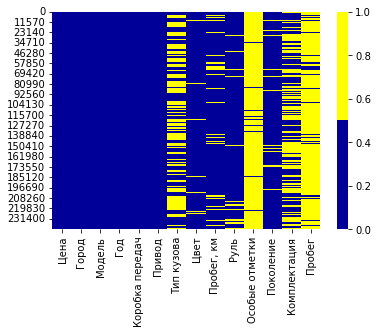

In [5]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [6]:
#Составим список признаков, у которых более 95% строк содержат одно и то же значение.

num_rows = len(data.index)
low_information_cols = [] #

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Особые отметки: 96.73351%
NaN                                                                                       235016
требуется ремонт или не на ходу                                                             5603
документы с проблемами или отсутствуют                                                       993
требуется ремонт или не на ходу, документы с проблемами или отсутствуют                      143
документы с проблемами, конструктор                                                           32
                                                                                           ...  
документы с проблемами, учёт КZ                                                                1
документы с проблемами, неоформленный конструктор                                              1
документы с проблемами, конструктор, грузовая таможенная декларация                            1
документы с проблемами, учет Казахстан                                                         1
доку

In [7]:
###Baseline

In [8]:
def catboost(data):
    cat_feat = data.select_dtypes(include=['object']).columns.tolist()
    y = data['Цена']
    X = data.drop('Цена', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = CatBoostRegressor(cat_features=cat_feat, iterations=2000,metric_period=100)
    
    model.fit(X_train, y_train)
    
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    return model, mae_train, mae_test

In [9]:
model, mae_train, mae_test = catboost(data.fillna('неизвестно'))

Learning rate set to 0.052104
0:	learn: 1595030.7902032	total: 601ms	remaining: 20m 1s
100:	learn: 631770.8991607	total: 44s	remaining: 13m 48s
200:	learn: 548534.5660868	total: 1m 25s	remaining: 12m 47s
300:	learn: 515722.4788587	total: 2m 13s	remaining: 12m 32s
400:	learn: 486765.9196417	total: 2m 58s	remaining: 11m 53s
500:	learn: 458172.4621646	total: 3m 44s	remaining: 11m 11s
600:	learn: 440402.9579388	total: 4m 28s	remaining: 10m 26s
700:	learn: 422821.4034530	total: 5m 14s	remaining: 9m 43s
800:	learn: 410556.2742485	total: 6m	remaining: 8m 58s
900:	learn: 400703.9602711	total: 6m 45s	remaining: 8m 14s
1000:	learn: 390683.1484487	total: 7m 43s	remaining: 7m 42s
1100:	learn: 380335.1963757	total: 8m 33s	remaining: 6m 59s
1200:	learn: 373791.7087202	total: 9m 23s	remaining: 6m 15s
1300:	learn: 368978.1634167	total: 10m 16s	remaining: 5m 31s
1400:	learn: 360848.3498859	total: 11m 15s	remaining: 4m 48s
1500:	learn: 354205.6093553	total: 12m 14s	remaining: 4m 4s
1600:	learn: 349720.1

In [10]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 142425.28677603052
MAE test: 146503.70936191131


In [11]:
#####

In [12]:
data.shape

(242952, 14)

In [13]:
data.head()

,Цена,Город,Модель,Год,Коробка передач,Привод,Тип кузова,Цвет,"Пробег, км",Руль,Особые отметки,Поколение,Комплектация,Пробег
0,915000,Якутск,Toyota Allion,2011,вариатор,4WD,NaN,серый,130 000,правый,NaN,"2 поколение, рестайлинг",1.8 A18 G package luxury edition 4WD,NaN
1,599000,Владивосток,Toyota Allion,2007,вариатор,передний,NaN,голубой,150 000,правый,NaN,2 поколение,1.8 A18 S package,NaN
2,680000,Находка,Toyota Allion,2007,вариатор,передний,NaN,зеленый,235 000,правый,NaN,2 поколение,NaN,NaN
3,777777,Большой Камень,Toyota Allion,2008,вариатор,передний,NaN,черный,156 270,правый,NaN,2 поколение,1.8 A18 S package,NaN
4,750000,Иркутск,Toyota Allion,2007,вариатор,передний,NaN,зеленый,199 000,правый,NaN,2 поколение,1.8 A18,NaN


In [14]:
#Не содержатся ли в данных какие-то символы, которые могли остаться при парсинге

def find_substring(values):
    values = str(values)
    extensionsToCheck = ["[", "]", "{", "}","_"]
    if any(ext in values for ext in extensionsToCheck):
        return True
    else:
        return False
    
for column in data.columns:
    print("{}, плохих значений {}".format(column,data[column].apply(find_substring).sum()))

Цена, плохих значений 0
Город, плохих значений 0
Модель, плохих значений 0
Год, плохих значений 0
Коробка передач, плохих значений 0
Привод, плохих значений 0
Тип кузова, плохих значений 0
Цвет, плохих значений 0
Пробег, км, плохих значений 0
Руль, плохих значений 0
Особые отметки, плохих значений 0
Поколение, плохих значений 0
Комплектация, плохих значений 0
Пробег, плохих значений 0


In [15]:
cat_feat = data.select_dtypes(include=['object']).columns.tolist()
for i in cat_feat:
    print("{}, уникальных значений {}".format(i, data[i].nunique()))

Город, уникальных значений 2384
Модель, уникальных значений 351
Коробка передач, уникальных значений 5
Привод, уникальных значений 3
Тип кузова, уникальных значений 11
Цвет, уникальных значений 16
Пробег, км, уникальных значений 46639
Руль, уникальных значений 2
Особые отметки, уникальных значений 850
Поколение, уникальных значений 50
Комплектация, уникальных значений 11688
Пробег, уникальных значений 1


In [16]:
def generation(values):
    try:
        string_list = values.split(' ')
        return string_list[0]
    except:
        return -1
    
def restyling(values):
    find_subst='рестайлинг'
    try:
        string_list = values.split(' ')
        if find_subst in string_list:
            return 1
        else:
            return 0
    except:
        return -1
    
data['Поколение'] = data['Поколение'].apply(generation)
data['Рестайлинг'] = data['Поколение'].apply(restyling)

In [17]:
data['Проблема с документами'] = data['Особые отметки'].apply(lambda x: 1 if str(x) in 'документы' else 0)
data['Ремонт'] = data['Особые отметки'].apply(lambda x: 1 if str(x) in ['ремонт','не на ходу'] else 0)

In [18]:
def body_type(values):        
    try:
        string_list = values.split(' ')
        if '/' in string:
            return string.split('/')[0]
        else:
            return string_list[0]
    except:
        if isinstance(values, float):
            return 'неизвестно'
        else:
            values
            
data['Тип кузова'] = data['Тип кузова'].apply(body_type)

In [19]:
data['Пробег, км'] = data['Пробег, км'].fillna(0)
data['Новый автомобиль'] = data['Пробег'].apply(lambda x: 1 if str(x) in 'новый автомобиль' else 0)

In [20]:
data = data.drop(['Пробег','Особые отметки','Пробег'], axis=1)
data['Комплектация'] = data['Комплектация'].fillna('unknown')

In [21]:
data[['Коробка передач','Привод','Тип кузова','Цвет','Руль']] = data[['Коробка передач','Привод','Тип кузова','Цвет','Руль']].fillna('неизвестно')

In [22]:
def mileage_russia(values):
    try:
        string_list = values.split(',')
        if 'б/п по РФ' in string_list:
            return 1
        else:
            return 0
    except:
        return 0

data['Пробег по РФ'] = data['Пробег, км'].apply(mileage_russia)  

In [23]:
def unicode_to_int(values):
    values = unidecode.unidecode(values)
    values = values.replace(' ','')
    return int(values)

def milliage(values):
    try:
        values = unicode_to_int(values)
        return values
    except:
        try:
            string_list = values.split(',')
            if 'б/п по РФ' in string_list and len(string_list)==1:
                return 0
            else:
                return unicode_to_int(string_list[0])
        except:
            return int(values)
        
     
data['Пробег, км'] = data['Пробег, км'].apply(milliage)
data['Пробег, км'] = data['Пробег, км'].astype('int')
data['Поколение'] = data['Поколение'].astype('int')

In [24]:
data.dtypes

Цена                       int64
Город                     object
Модель                    object
Год                        int64
Коробка передач           object
Привод                    object
Тип кузова                object
Цвет                      object
Пробег, км                 int32
Руль                      object
Поколение                  int32
Комплектация              object
Рестайлинг                 int64
Проблема с документами     int64
Ремонт                     int64
Новый автомобиль           int64
Пробег по РФ               int64
dtype: object

In [25]:
model, mae_train, mae_test = catboost(data)

Learning rate set to 0.052104
0:	learn: 1597038.4758087	total: 307ms	remaining: 10m 14s
100:	learn: 619782.7954368	total: 25.7s	remaining: 8m 2s
200:	learn: 540994.9923516	total: 49.4s	remaining: 7m 22s
300:	learn: 496121.6992760	total: 1m 13s	remaining: 6m 53s
400:	learn: 463775.5516372	total: 1m 37s	remaining: 6m 27s
500:	learn: 444185.8921403	total: 2m 1s	remaining: 6m 4s
600:	learn: 424847.4952291	total: 2m 26s	remaining: 5m 40s
700:	learn: 408181.2993419	total: 2m 50s	remaining: 5m 15s
800:	learn: 393902.0266093	total: 3m 14s	remaining: 4m 50s
900:	learn: 384975.4928369	total: 3m 38s	remaining: 4m 26s
1000:	learn: 378660.6152533	total: 4m 3s	remaining: 4m 2s
1100:	learn: 370026.7701770	total: 4m 27s	remaining: 3m 38s
1200:	learn: 363934.5756959	total: 4m 52s	remaining: 3m 14s
1300:	learn: 358981.9109022	total: 5m 16s	remaining: 2m 49s
1400:	learn: 354098.0960253	total: 5m 39s	remaining: 2m 25s
1500:	learn: 348491.1851997	total: 6m 3s	remaining: 2m
1600:	learn: 344778.7542296	total

In [26]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 141703.29593923705
MAE test: 146720.5735402735


In [27]:
data_with_encoding = pd.get_dummies(data, columns=['Коробка передач','Привод','Тип кузова','Цвет','Руль'])

In [28]:
model, mae_train, mae_test = catboost(data_with_encoding)

Learning rate set to 0.052104
0:	learn: 1600849.2812786	total: 145ms	remaining: 4m 50s
100:	learn: 639169.9867747	total: 14.4s	remaining: 4m 31s
200:	learn: 558967.5510914	total: 28.1s	remaining: 4m 11s
300:	learn: 506553.9365268	total: 41.3s	remaining: 3m 53s
400:	learn: 470476.6285097	total: 54.2s	remaining: 3m 36s
500:	learn: 440464.7561636	total: 1m 7s	remaining: 3m 23s
600:	learn: 422212.2001640	total: 1m 21s	remaining: 3m 10s
700:	learn: 406718.2340112	total: 1m 35s	remaining: 2m 56s
800:	learn: 393162.1672563	total: 1m 47s	remaining: 2m 41s
900:	learn: 381811.4215093	total: 2m	remaining: 2m 27s
1000:	learn: 374008.9218928	total: 2m 14s	remaining: 2m 13s
1100:	learn: 366354.4757451	total: 2m 27s	remaining: 2m
1200:	learn: 360079.0550523	total: 2m 40s	remaining: 1m 46s
1300:	learn: 354170.3037377	total: 2m 53s	remaining: 1m 33s
1400:	learn: 348992.7411558	total: 3m 6s	remaining: 1m 19s
1500:	learn: 344209.5507929	total: 3m 19s	remaining: 1m 6s
1600:	learn: 340240.9766084	total: 3m

In [29]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 140228.53869544165
MAE test: 145922.73298892807


In [30]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

In [34]:
def catboost_tune(data):
    cat_feat = data.select_dtypes(include=['object']).columns.tolist()

    y = data['Цена']
    X = data.drop('Цена', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE')
    
#     parameters = {'depth': [4,6,7,8,10],
#                   'learning_rate' : [0.01, 0.1, 0.2],
#                   'iterations'    : [800,1000, 1200,1500, 2000]
#                  }
#     parameters = {
#         #'depth': [5,6,7],
#         'learning_rate' : [0.2,0.25,0.3],
#         'iterations'    : [1500,2000,2500]
#                  }
    
    parameters = {
        'learning_rate' : [0.2],
        'iterations'    : [2500]
                 }
    
    Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=3, scoring='neg_mean_absolute_error', verbose=10)
    Grid_CBC.fit(X_train, y_train)
    
    #Grid_CBC = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 3, n_jobs=3, scoring='neg_mean_absolute_error', n_iter=15)
    #Grid_CBC.fit(X_train, y_train)
    
    print(" Results from Grid Search " )
    print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
    print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
    
    best_model = Grid_CBC.best_estimator_
    
    preds_train = best_model.predict(X_train)
    preds_test = best_model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    return best_model, mae_train, mae_test,X_train, y_train, cat_feat

In [ ]:
best_model, mae_train, mae_test,X_train, y_train, cat_feat = catboost_tune(data_with_encoding)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [35]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 131686.12015359398
MAE test: 139622.16916627705


In [62]:
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_feat))

In [63]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

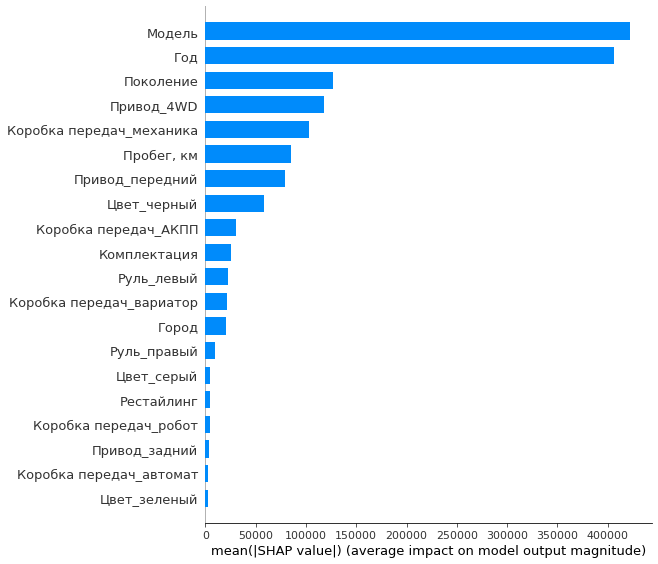

In [64]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

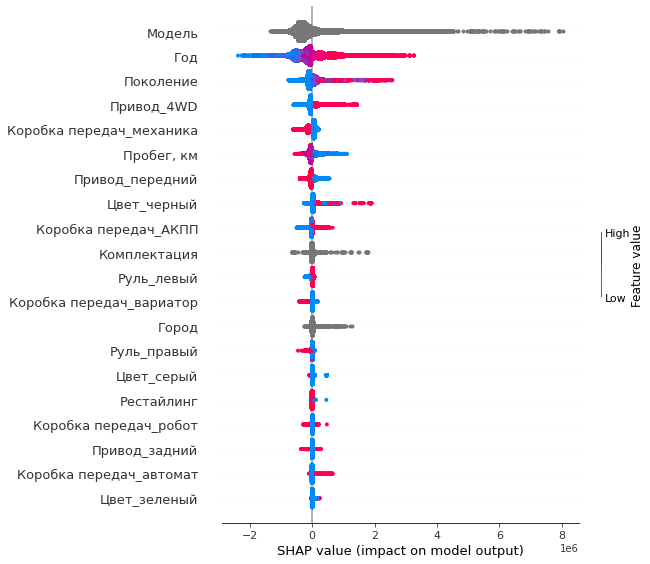

In [65]:
shap.summary_plot(shap_values, X_train)